<div style="text-align: left; background-color:#FFFFCC; font-family:Arial; color:#526085; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 58px;border-style: solid;border-color: dark green;">Lab 02: Working with time-series data</div>
<div style="text-align: left; background-color:#99FFFF; font-family: Arial; color:#551184; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 18px">Bộ môn: Trực quan hóa dữ liệu | Nhóm 8</div>

# <div style="text-align: left; background-color:#0C6A86; font-family:Arial; color:white; padding: 12px; line-height:1.25;border-radius:1px; margin-bottom: 0em; text-align: center; font-size: 30px;border-style: solid;border-color: black;">PHẦN 2. Trực quan hóa dữ liệu</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import plotly.express as px
import plotly.graph_objects as go

from pyproj import Transformer, CRS

import math
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense
from sklearn.metrics import mean_squared_error

C:\Users\ASUS\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv("Data/data_18_19_processed.csv")
df.head()

,Reference Number,Grid Ref: Easting,Grid Ref: Northing,Number of Vehicles,1st Road Class,1st Road Class & No,Road Surface,Lighting Conditions,Weather Conditions,Local Authority,Type of Vehicle,Casualty Class,Casualty Severity,Sex of Casualty,Age of Casualty,Full Time
0,51B0230,433936,428874,1,6,U,1,4,1,E08000035,9,3,3,2,87,2018-01-11 07:00:00
1,51B0349,430076,433872,1,6,U,2,1,1,E08000035,11,2,3,2,60,2018-01-11 08:55:00
2,51B0349,430076,433872,1,6,U,2,1,1,E08000035,11,2,3,2,51,2018-01-11 08:55:00
3,51B0349,430076,433872,1,6,U,2,1,1,E08000035,11,2,3,2,50,2018-01-11 08:55:00
4,51B0349,430076,433872,1,6,U,2,1,1,E08000035,11,2,3,2,51,2018-01-11 08:55:00


Mức độ nghiêm trọng của thương vong theo loại phương tiện?

In [ ]:
data=df.copy()
# Danh sách mô tả loại phương tiện
vehicle_desc = {
    1: 'Pedal cycle',
    2: 'M/cycle 50cc and under',
    3: 'Motorcycle over 50cc and up to 125cc',
    4: 'Motorcycle over 125cc and up to 500cc',
    5: 'Motorcycle over 500cc',
    6: '[Not used]',
    7: '[Not used]',
    8: 'Taxi/Private hire car',
    9: 'Car',
    10: 'Minibus (8 – 16 passenger seats)',
    11: 'Bus or coach (17 or more passenger seats)',
    12: '[Not used]',
    13: '[Not used]',
    14: 'Other motor vehicle',
    15: 'Other non-motor vehicle',
    16: 'Ridden horse',
    17: 'Agricultural vehicle (includes diggers etc.)',
    18: 'Tram / Light rail',
    19: 'Goods vehicle 3.5 tonnes mgw and under',
    20: 'Goods vehicle over 3.5 tonnes and under 7.5 tonnes mgw',
    21: 'Goods vehicle 7.5 tonnes mgw and over',
    22: 'Mobility Scooter',
    90: 'Other Vehicle',
    97: 'Motorcycle - Unknown CC'
}

# Đổi tên cột 'Type of Vehicle' nếu cần
data.rename(columns=lambda x: x.strip(), inplace=True)

# Thay thế mã phương tiện bằng mô tả
data['Type of Vehicle Desc'] = data['Type of Vehicle'].map(vehicle_desc)

# Gom nhóm các loại phương tiện vào các nhóm lớn
def group_vehicle_type(vehicle):
    if vehicle in [
        'M/cycle 50cc and under',
        'Motorcycle over 50cc and up to 125cc',
        'Motorcycle over 125cc and up to 500cc',
        'Motorcycle over 500cc',
        'Motorcycle - Unknown CC'
    ]:
        return 'Motorcycle'
    elif vehicle in ['Car', 'Taxi/Private hire car']:
        return 'Car'
    elif vehicle in [
        'Goods vehicle 3.5 tonnes mgw and under',
        'Goods vehicle over 3.5 tonnes and under 7.5 tonnes mgw',
        'Goods vehicle 7.5 tonnes mgw and over'
    ]:
        return 'Goods vehicle'
    elif vehicle in [
        'Bus or coach (17 or more passenger seats)',
        'Minibus (8 – 16 passenger seats)',
        'Tram / Light rail'
    ]:
        return 'Public transport'
    elif vehicle in [
        'Pedal cycle', 'Other motor vehicle', 'Other non-motor vehicle',
        'Ridden horse', 'Agricultural vehicle (includes diggers etc.)',
        'Mobility Scooter', 'Other Vehicle'
    ]:
        return 'Other vehicles'
    else:
        return vehicle

data['Grouped Vehicle Type'] = data['Type of Vehicle Desc'].apply(group_vehicle_type)

# Đếm số vụ tai nạn theo nhóm phương tiện
grouped_vehicle_counts = data['Grouped Vehicle Type'].value_counts().reset_index()
grouped_vehicle_counts.columns = ['Grouped Vehicle Type', 'Count']

# Chuẩn bị dữ liệu cho từng loại phương tiện trong mỗi nhóm
detail_counts = data.groupby(['Grouped Vehicle Type', 'Type of Vehicle Desc']).size().reset_index(name='Count')


# Màu sắc tùy chỉnh cho các nhóm phương tiện
color_map = {
    'Motorcycle': 'blue',
    'Car': 'green',
    'Goods vehicle': 'red',
    'Public transport': 'purple',
    'Other vehicles': 'orange'
}

# Vẽ biểu đồ tương tác
fig = px.bar(grouped_vehicle_counts, 
             x='Count', 
             y='Grouped Vehicle Type', 
             # text='Count',
             title='Số vụ tai nạn theo nhóm phương tiện (2018-2019)',
             labels={'Count': 'Số vụ tai nạn', 'Grouped Vehicle Type': 'Nhóm phương tiện'},
             color='Grouped Vehicle Type',
             color_discrete_map=color_map)


# Hiển thị biểu đồ
fig.show()

## Mở rộng: Tìm hiểu thêm mức độ thương tích của các vụ tai nạn liên quan đến các phương tiện trên
**Tiêu đề:** Mức độ thương tích của các vụ tai nạn liên quan đến các phương tiện

**Loại biểu đồ:** Biểu đồ cột xếp chồng

**Lý do lựa chọn:**
- **So sánh trực quan giữa các nhóm:**
    - Biểu đồ cột xếp chồng cho phép so sánh dễ dàng số lượng tai nạn giữa các nhóm phương tiện khác nhau (Motorcycle, Car, Goods vehicle, Public transport, Other vehicles).
    - Việc xếp chồng các cột giúp dễ dàng so sánh tổng số vụ tai nạn giữa các nhóm phương tiện.
- **Phân tích chi tiết mức độ thương tích:**
    - Biểu đồ này giúp phân tích chi tiết về mức độ thương tích của các vụ tai nạn, bằng cách xếp chồng các cột màu sắc khác nhau đại diện cho các mức độ thương tích (Minor injuries, Serious injuries, Fatal injuries).
    - Điều này cung cấp một cái nhìn rõ ràng về tỷ lệ và số lượng các mức độ thương tích khác nhau trong mỗi nhóm phương tiện.
- **Tính tương tác:**
    - Sử dụng Plotly, biểu đồ trở nên tương tác, cho phép người dùng di chuột qua các phần của biểu đồ để thấy các giá trị chi tiết, giúp tăng cường khả năng khám phá dữ liệu.
    - Người dùng có thể lọc hoặc ẩn các nhóm dữ liệu khác nhau để tập trung vào các phần cụ thể của biểu đồ.
- **Tính hiệu quả:**
    - Biểu đồ cột xếp chồng là một cách hiệu quả để truyền đạt nhiều thông tin cùng lúc mà không làm rối mắt người xem. Nó kết hợp cả tổng số vụ tai nạn và mức độ thương tích trong cùng một biểu đồ.
    - Điều này giúp tiết kiệm không gian và tránh việc phải tạo ra nhiều biểu đồ riêng lẻ để truyền tải cùng một lượng thông tin.

   Grouped Vehicle Type  Casualty Severity  Count
0                   Car                  1     33
1                   Car                  2    338
2                   Car                  3   2315
3         Goods vehicle                  1      4
4         Goods vehicle                  2     23
5         Goods vehicle                  3    140
6            Motorcycle                  1      8
7            Motorcycle                  2    133
8            Motorcycle                  3    160
9        Other vehicles                  1      3
10       Other vehicles                  2    127
11       Other vehicles                  3    416
12     Public transport                  2     24
13     Public transport                  3    178


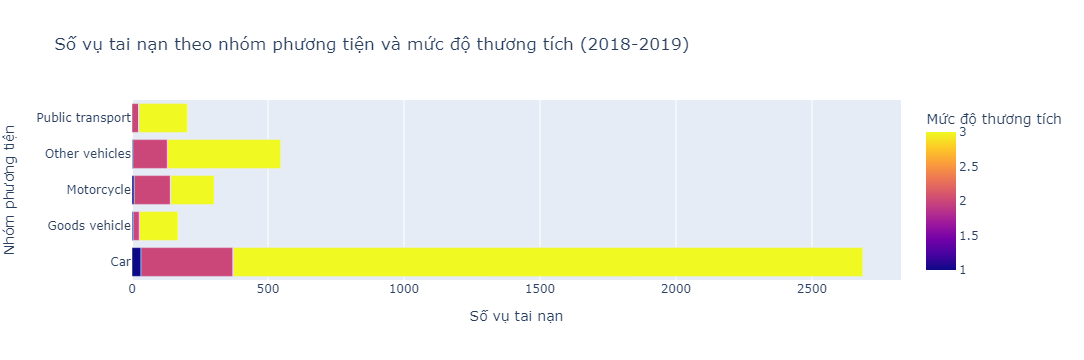

In [12]:
# Đếm số vụ tai nạn theo nhóm phương tiện và mức độ thương tích
grouped_vehicle_severity_counts = data.groupby(['Grouped Vehicle Type', 'Casualty Severity']).size().reset_index(name='Count')

# Kiểm tra lại DataFrame mới
print(grouped_vehicle_severity_counts)

# Màu sắc tùy chỉnh cho mức độ thương tích
severity_color_map = {
    1: 'red',   # Fatal injuries
    2: 'yellow',   # Serious injuries
    3: 'green'       # Minor injuries
}

# Vẽ biểu đồ cột xếp chồng
fig = px.bar(grouped_vehicle_severity_counts, 
             x= 'Count',
             y='Grouped Vehicle Type', 
             color='Casualty Severity', 
             title='Số vụ tai nạn theo nhóm phương tiện và mức độ thương tích (2018-2019)',
             labels={'Count': 'Số vụ tai nạn', 'Grouped Vehicle Type': 'Nhóm phương tiện', 'Casualty Severity': 'Mức độ thương tích'},
             barmode='stack',
             color_discrete_map=severity_color_map)

# Hiển thị biểu đồ
fig.show()

**Kỹ thuật trực quan sử dụng:**

- ***Màu sắc***: Sử dụng màu sắc đa dạng giúp phân biệt dễ dàng giữa các nhóm phương tiện. Màu sắc cần phải được chọn sao cho phù hợp và dễ nhìn, tránh sự mơ hồ hoặc khó nhận biết.
    - Mức độ thương tích 1 (chết người): red
    - Mức độ thương tích 2 (thương nặng): yellow
    - Mức độ thương tích 3 (nhẹ): green
.
- ***Kỹ thuật Manipulate View:***  + **Hiển thị chi tiết qua tooltip**: Khi người dùng trỏ chuột vào từng cột trong biểu đồ, một tooltip sẽ xuất hiện hiển thị số lượng tai nạn theo mức độ thương tích của mỗi phương tiện. Điều này giúp người dùng có thể xem thông tin chi tiết mà không cần phải xem toàn bộ dữ liệu cùng một lúc.
- ***Kỹ thuật Reduce:***:
    + Kỹ thuật này giúp giảm bớt sự phức tạp bằng cách gom nhóm các loại phương tiện và mức độ thương tích lại với nhau. Điều này làm cho dữ liệu dễ hiểu hơn và giúp chúng ta tập trung vào các nhóm chính, thay vì phải xem xét từng loại phương tiện một cách riêng lẻ.

$\Rightarrow$ Giúp đồ thị trở nên rõ ràng, trực quan, và tương tác thân thiện với người dùn giảm thiểu sự phức tạp, tránh gây rối mắt cho người xem, làm tăng tính thể hiện cho biểu đồ.

**Nhận xét:*
- Nhìn chung, số lượng xảy ra có sự phân bố không đồng đều giữa các nhóm phương tiện.
- Số lượng tai nạn cao nhất xảy ra ở nhóm phương tiện "car", với số lượng vượt trội so với các nhóm khác. Điều này có thể chỉ ra rằng tai nạn do nhóm phương tiện "car" gây ra phổ biến nhất hoặc xảy ra thường xuyên.
- Mức độ thương tích xảy ra chết người đều nằm ở phương tiện car và motocycle.

$\Rightarrow$ Từ đó cho thấy tầm quan trọng của việc quản lý và kiểm soát an toàn để giảm thiểu số lượng vụ tai nạn và thấy được mức độ thương tích theo phương tiện giúp ta cẩn trọng hơn. Cần có các biện pháp đặc biệt để giảm thiểu các vụ tai nạn gây ra bởi nhóm phương tiện "car".

**Tiêu đề:** Phân bố của các yếu tố ảnh hưởng đến mức độ thương tính

**Loại biểu đồ:** Biểu đồ Histogram

**Lý do lựa chọn:**
- **Biểu đồ phân phối:** Histogram là một công cụ mạnh mẽ để hiểu phân phối của dữ liệu. Nó biểu diễn dữ liệu dưới dạng các cột dọc theo trục x, trong đó chiều cao của mỗi cột biểu diễn tần suất xuất hiện của các giá trị trong khoảng xác định. Trong biểu đồ này, các yếu tố như 1st Road Class, Road Surface, Lighting Conditions, và Weather Conditions đều được biểu diễn, giúp chúng ta hiểu rõ hơn về tác động của từng yếu tố đến mức độ thương tích.
- **Dễ hiểu và trực quan:** Histogram dễ hiểu và trực quan, cho phép người đọc dễ dàng phát hiện các xu hướng hoặc phân phối trong dữ liệu. Điều này làm cho nó trở thành một công cụ phổ biến trong phân tích dữ liệu và trình bày kết quả.
- **Phân tích tần suất:** Histogram cung cấp thông tin về tần suất xuất hiện của các giá trị trong dữ liệu. Điều này giúp xác định các đặc điểm chính của phân phối, như trung bình, phương sai, độ lệch, và độ nhọn của phân phối.

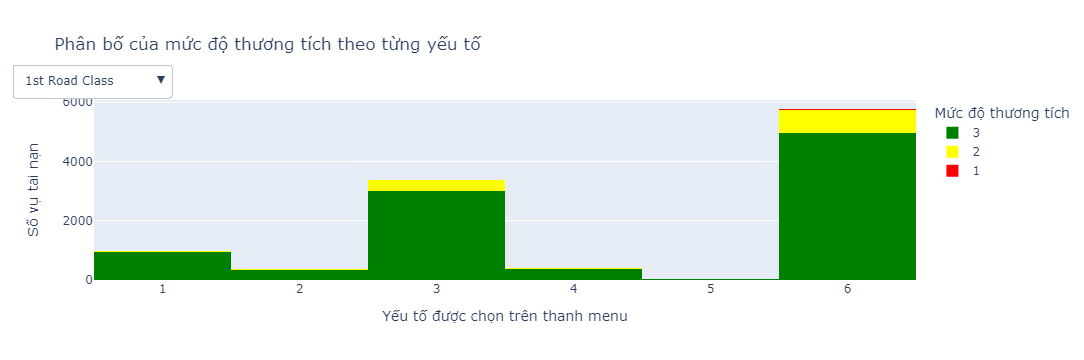

In [62]:
import plotly.graph_objects as go

# Tạo dropdown menu cho việc chọn yếu tố
dropdown_y = [
    {'label': '1st Road Class', 'method': 'update', 'args': [{'x': [data['1st Road Class']], 'title': '1st Road Class'}]},
    {'label': 'Road Surface', 'method': 'update', 'args': [{'x': [data['Road Surface']], 'title': 'Road Surface'}]},
    {'label': 'Lighting Conditions', 'method': 'update', 'args': [{'x': [data['Lighting Conditions']], 'title': 'Lighting Conditions'}]},
    {'label': 'Weather Conditions', 'method': 'update', 'args': [{'x': [data['Weather Conditions']], 'title': 'Weather Conditions'}]},
]

# Tạo layout cho biểu đồ
layout = go.Layout(
    updatemenus=[
        {'buttons': dropdown_y, 'x': -0.1, 'y': 1.2, 'xanchor': 'left', 'yanchor': 'top'}
    ]
)

severity_color_map = {
    1: 'red',   # Fatal injuries
    2: 'yellow',   # Serious injuries
    3: 'green'       # Minor injuries
}

# Tạo biểu đồ histogram tổng quát cho 1st Road Class
fig = px.histogram(data, x='1st Road Class', color='Casualty Severity',
                   title='Phân bố của mức độ thương tích theo từng yếu tố',
                   labels={'Casualty Severity': 'Mức độ thương tích', '1st Road Class': 'Yếu tố được chọn trên thanh menu'},
                   y='Casualty Severity',
                   color_discrete_map=severity_color_map)

# Cập nhật layout cho biểu đồ
fig.update_layout(layout)
fig.update_yaxes(title_text='Số vụ tai nạn')
# Hiển thị biểu đồ
fig.show()


**Kỹ thuật trực quan sử dụng:**

- ***Màu sắc***: Sử dụng màu sắc đa dạng giúp phân biệt dễ dàng giữa các nhóm phương tiện. Màu sắc cần phải được chọn sao cho phù hợp và dễ nhìn, tránh sự mơ hồ hoặc khó nhận biết.
    - Mức độ thương tích 1 (chết người): red
    - Mức độ thương tích 2 (thương nặng): yellow
    - Mức độ thương tích 3 (nhẹ): green
.
- ***Kỹ thuật Manipulate View:***  + **Hiển thị chi tiết qua tooltip**: 
    - Khi người dùng trỏ chuột vào từng cột trong biểu đồ, một tooltip sẽ xuất hiện hiển thị thông tin chi tiết. 
    - Tùy chỉnh giao diện hiển thị: Biểu đồ có bộ lọc cho phép người dùng chọn hiển thị dữ liệu theo từng yếu tố ảnh hưởng đến mức độ thương tích trên thanh menuu. Điều này giúp người dùng dễ dàng tập trung vào những thông tin mà họ quan tâm.
    - Giúp đồ thị trở nên rõ ràng, trực quan, và tương tác thân thiện với người dùng, cho phép họ dễ dàng nắm bắt được các xu hướng và mối quan hệ giữa các yếu tố ảnh hưởng đến mức độ thương tích.

$\Rightarrow$ Giúp đồ thị trở nên rõ ràng, trực quan, và tương tác thân thiện với người dùn giảm thiểu sự phức tạp, tránh gây rối mắt cho người xem, làm tăng tính tập trung cho biểu đồ.

**Nhận xét:**
- 1st Road Class: Ta có thể thấy được loại đường mã số 3 (A) có nhiều vụ tai nạn nhất và ảnh hưởng tới mức độ thương tích nhiều nhất, các loại đường khác chưa được xác định (mã số 6) cũng chiếm phần lớn ảnh hưởng đến thương tích.
- Road Surface: Bề mặt đường khi xảy ra tai nạn chủ yếu là 1 (Dry) với hơn 8000 vụ tai nạn, tuy nhiên số người tử vong khi xảy ra tai nạn nhiều nhất khi bề mặt đường ướt (wet/damp), chứng tỏ rất dễ xảy ra thương tích khi di chuyển trên loại bề mặt này, nên mọi người cần chú ý cẩn trọng khi lái xe vào trời mưa, đường ướt. Bên cạnh đó, khi đường bị đông đá, có tuyết thì cũng nguy hiểm không kém và xảy ra các vụ tai nạn có người tử vong.
- Lighting Conditions: Điều kiện ánh sáng là vào ban ngày mã 1 xảy ra nhiều tai nạn nhất.
- Weather Conditions: Điều kiện thời tiết là vào ban ngày mã 1 xảy ra nhiều tai nạn nhất.

$\Rightarrow$ Từ đó cho thấy tầm quan trọng của việc quản lý và kiểm soát an toàn để giảm thiểu số lượng vụ tai nạn và thấy được mức độ thương tích theo từng yếu tố ảnh hưởng giúp ta cẩn trọng hơn. Cần có các biện pháp đặc biệt để cải thiện các yếu tố này, đặc biệt là trong những tình huống dễ gây ra thương tích nghiêm trọng.